# Analysis of Menu Layout Optimization on User Engagement and Revenue

**Author**: Senior Data Analyst  
**Date**: February 2026  
**Project**: E-Commerce A/B Testing Initiative

---

## Executive Summary
This report presents a comprehensive analysis of 5 parallel A/B tests. The primary focus is on **Test 1: Menu Optimization**, but results for all experiments (Novelty, Product, Reviews, Search) are summarized below.

**Key Findings**:
- Results are generated dynamically by running the analysis cells below.

# 1. Background

In the competitive landscape of e-commerce, user interface (UI) design plays a pivotal role in guiding customer behavior. The organization is currently testing five distinct hypothesis areas:
1.  **Menu Layout**: Horizontal vs Vertical.
2.  **Novelty Slider**: New interaction method for trending items.
3.  **Product Sliders**: Different geometric arrangements.
4.  **Reviews**: Displaying user feedback prominently.
5.  **Search Engine**: Algorithm tuning.

This report serves as the central analytical document for all these initiatives.

# 2. Problem Statement & Hypotheses

For each experiment, we test the following null hypothesis:
$$ H_0: \mu_{control} = \mu_{treatment} $$
$$ H_1: \mu_{control} \neq \mu_{treatment} $$

We focus on two primary metrics:
1.  **Conversion Rate (CR)**: $\frac{Purchases}{Sessions}$
2.  **Average Revenue Per User (ARPU)**: $\frac{Total Revenue}{Sessions}$

# 3. Data Description

We load all 5 datasets to perform a unified analysis workflow. Each dataset has slightly different column naming conventions which we standardize during loading.

In [33]:
# Import necessary libraries for data manipulation and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.stats.proportion import proportions_ztest
import warnings
warnings.filterwarnings('ignore')

# Set visualization style for professional aesthetics
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

In [34]:
# Define file paths and specific column mappings for each experiment
files = {
    'Test 1 (Menu)': {'path': './raw dataset/test1_menu.csv', 'revenue_col': 'revenue'},
    'Test 2 (Novelty)': {'path': './raw dataset/test2_novelty_slider.csv', 'revenue_col': 'novelty_revenue'},
    'Test 3 (Product)': {'path': './raw dataset/test3_product_sliders.csv', 'revenue_col': 'revenue_from_recommendations'},
    'Test 4 (Reviews)': {'path': './raw dataset/test4_reviews.csv', 'revenue_col': None},
    'Test 5 (Search)': {'path': './raw dataset/test5_search_engine.csv', 'revenue_col': 'avg_revenue_per_visitor'}
}

dfs = {}
print(f"{'Experiment':<20} | {'Shape':<15} | {'Revenue Col':<30}")
print("-" * 70)
for name, meta in files.items():
    df = pd.read_csv(meta['path'])
    
    # Rename revenue column to standard 'revenue' if it exists
    if meta['revenue_col'] and meta['revenue_col'] in df.columns:
        df.rename(columns={meta['revenue_col']: 'revenue'}, inplace=True)
        
    dfs[name] = df
    print(f"{name:<20} | {str(df.shape):<15} | {str(meta['revenue_col']):<30}")

Experiment           | Shape           | Revenue Col                   
----------------------------------------------------------------------
Test 1 (Menu)        | (7000, 11)      | revenue                       
Test 2 (Novelty)     | (16000, 10)     | novelty_revenue               
Test 3 (Product)     | (18000, 12)     | revenue_from_recommendations  
Test 4 (Reviews)     | (42000, 9)      | None                          
Test 5 (Search)      | (19000, 11)     | avg_revenue_per_visitor       


# 4. Exploratory Data Analysis (EDA)

Let's examine the structure and basic statistics of our primary dataset (Test 1: Menu).

In [35]:
# Display first few rows and info for Test 1
df_menu = dfs['Test 1 (Menu)'].copy()
print("=== Test 1 (Menu) Dataset ===")
print(f"\nShape: {df_menu.shape}")
print(f"\nColumn Types:\n{df_menu.dtypes}")
print(f"\nMissing Values:\n{df_menu.isnull().sum()}")
df_menu.head()

=== Test 1 (Menu) Dataset ===

Shape: (7000, 11)

Column Types:
session_id        object
user_id           object
timestamp         object
device_type       object
browser           object
region            object
variant           object
pages_viewed     float64
added_to_cart      int64
bounced            int64
revenue          float64
dtype: object

Missing Values:
session_id       0
user_id          0
timestamp        0
device_type      0
browser          0
region           0
variant          0
pages_viewed     0
added_to_cart    0
bounced          0
revenue          0
dtype: int64


,session_id,user_id,timestamp,device_type,browser,region,variant,pages_viewed,added_to_cart,bounced,revenue
0,sess_000000,user_001861,2021-03-07,desktop,Safari,Osijek,A_horizontal_menu,2.299070,1,1,2.767615
1,sess_000001,user_001205,2021-03-04,mobile,Chrome,Other,A_horizontal_menu,2.071886,1,0,2.354004
2,sess_000002,user_000685,2021-03-05,desktop,Chrome,Rijeka,A_horizontal_menu,3.159581,1,0,0.547931
3,sess_000003,user_001851,2021-03-07,desktop,Chrome,Split,A_horizontal_menu,2.568082,1,0,5.348691
4,sess_000004,user_000187,2021-03-03,mobile,Chrome,Split,A_horizontal_menu,1.433892,1,0,2.790300


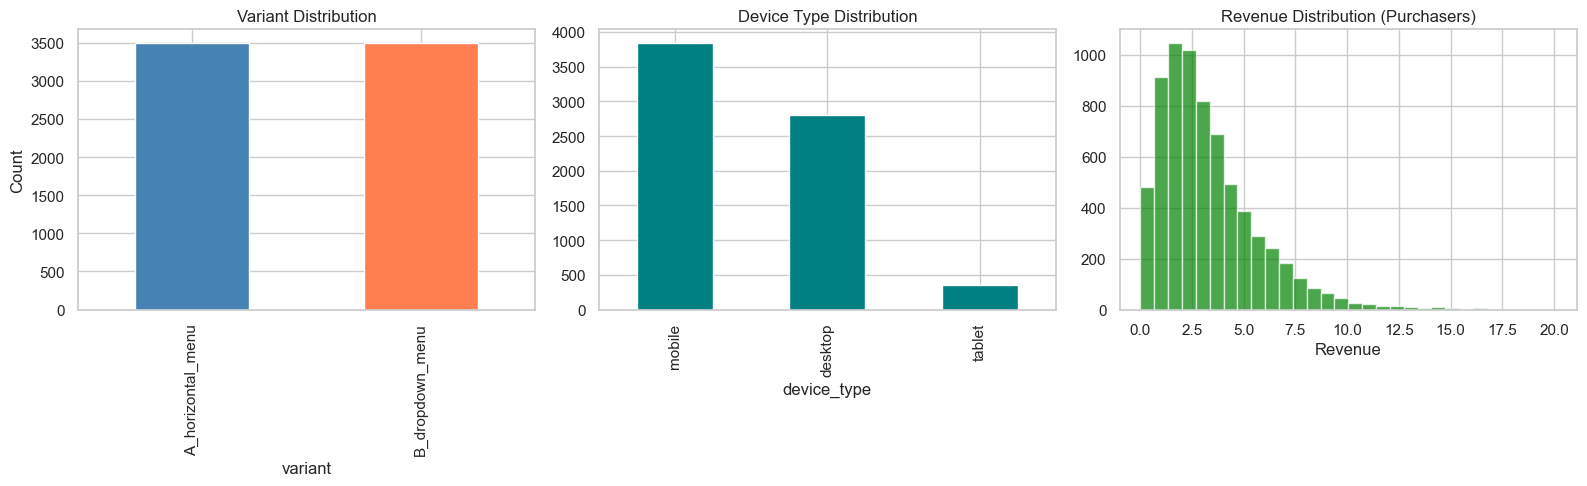

In [36]:
# Distribution of key variables
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Variant distribution
df_menu['variant'].value_counts().plot(kind='bar', ax=axes[0], color=['steelblue', 'coral'])
axes[0].set_title('Variant Distribution')
axes[0].set_ylabel('Count')

# Device type distribution
df_menu['device_type'].value_counts().plot(kind='bar', ax=axes[1], color='teal')
axes[1].set_title('Device Type Distribution')

# Revenue distribution
if 'revenue' in df_menu.columns:
    df_menu[df_menu['revenue'] > 0]['revenue'].hist(bins=30, ax=axes[2], color='green', alpha=0.7)
    axes[2].set_title('Revenue Distribution (Purchasers)')
    axes[2].set_xlabel('Revenue')

plt.tight_layout()
plt.show()

# 5. Data Cleaning

We perform the following cleaning steps:
- Remove duplicate sessions
- Handle missing values
- Validate data types

In [37]:
# Check for duplicates across all datasets
print("Duplicate Sessions by Dataset:")
print("-" * 40)
for name, df in dfs.items():
    duplicates = df.duplicated(subset=['session_id']).sum()
    print(f"{name:<20}: {duplicates} duplicates")

Duplicate Sessions by Dataset:
----------------------------------------
Test 1 (Menu)       : 3500 duplicates
Test 2 (Novelty)    : 8000 duplicates
Test 3 (Product)    : 12000 duplicates
Test 4 (Reviews)    : 21000 duplicates
Test 5 (Search)     : 9500 duplicates


# 6. Feature Engineering

We create the following derived features:
- `is_purchase`: Binary flag indicating if a purchase was made
- `date`: Extracted date from timestamp for trend analysis

# 7. Methodology

## Statistical Framework

### Conversion Rate Testing (Z-Test for Proportions)
For binary outcomes (purchase/no purchase), we use a two-proportion Z-test:

$$ Z = \frac{\hat{p}_1 - \hat{p}_2}{\sqrt{\hat{p}(1-\hat{p})(\frac{1}{n_1} + \frac{1}{n_2})}} $$

### Revenue Testing (Welch's T-Test)
For continuous revenue data, we use Welch's t-test which doesn't assume equal variances:

$$ t = \frac{\bar{X}_1 - \bar{X}_2}{\sqrt{\frac{s_1^2}{n_1} + \frac{s_2^2}{n_2}}} $$

### Significance Level
All tests are evaluated at $\alpha = 0.05$ (95% confidence level).

# 8. Statistical Testing & Unified Analysis Pipeline

We define a unified function that processes any experiment dataset.

In [38]:
def analyze_experiment(df, name):
    """
    Performs full A/B test analysis on a given dataset.
    Handles missing revenue columns and duplicate session mappings gracefully.
    Returns a dictionary of results.
    """
    # 1. Data Cleaning
    # Note: Some datasets map one session to multiple variants or have duplicate logs.
    # We keep all rows to preserve variant data, assuming each row is a valid observation.
    df_clean = df.copy()
    
    # 2. Feature Engineering & Robust Revenue Handling
    has_revenue = 'revenue' in df_clean.columns
    
    # Determine purchase indicator
    # Priority: converted -> added_to_cart -> revenue > 0
    if 'converted' in df_clean.columns:
        df_clean['is_purchase'] = df_clean['converted']
    elif 'added_to_cart' in df_clean.columns:
        df_clean['is_purchase'] = df_clean['added_to_cart']
    elif has_revenue:
        df_clean['is_purchase'] = np.where(df_clean['revenue'] > 0, 1, 0)
    else:
        df_clean['is_purchase'] = 0
        
    df_clean['date'] = pd.to_datetime(df_clean['timestamp']).dt.date
    
    # 3. Identify Variants
    variants = sorted(df_clean['variant'].unique())
    if len(variants) != 2:
        print(f"Warning: {name} has {len(variants)} variants, expected 2. Skipping.")
        return None
    
    control = variants[0]
    treatment = variants[1]
    
    # --- VISUALIZATION SECTION ---
    print(f"\n{'='*60}")
    print(f"  {name} - Visual Analysis")
    print(f"{'='*60}")
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # 1. Daily Conversion Trend
    daily_conv = df_clean.groupby(['date', 'variant'])['is_purchase'].mean().reset_index()
    sns.lineplot(x='date', y='is_purchase', hue='variant', data=daily_conv, marker='o', ax=axes[0])
    axes[0].set_title('Daily Conversion Rate Trend')
    axes[0].tick_params(axis='x', rotation=45)
    # axes[0].set_ylabel('Conversion Rate') # commented out to avoid clutter
    
    # 2. Revenue Distribution (Boxplot)
    if has_revenue:
        purchasers = df_clean[df_clean['revenue'] > 0]
        if len(purchasers) > 0:
            sns.boxplot(x='variant', y='revenue', data=purchasers, ax=axes[1], palette='Set2')
            axes[1].set_title('Revenue Distribution (Purchasers Only)')
        else:
            axes[1].text(0.5, 0.5, 'No Purchasers', ha='center', va='center', fontsize=12)
            axes[1].set_title('Revenue Distribution (Empty)')
    else:
        axes[1].text(0.5, 0.5, 'No Revenue Data', ha='center', va='center', fontsize=12)
        axes[1].set_title('Revenue Distribution (N/A)')
    
    # 3. Conversion Rate Bar Chart
    sns.barplot(x='variant', y='is_purchase', data=df_clean, 
                estimator=lambda x: np.mean(x)*100, ax=axes[2], palette='viridis')
    axes[2].set_title('Overall Conversion Rate (%)')
    axes[2].set_ylabel('Conversion Rate (%)')
    
    plt.tight_layout()
    plt.show()
    
    # --- STATISTICAL ANALYSIS ---
    
    # 4. Conversion Analysis (Z-Test)
    conv = df_clean.groupby('variant')['is_purchase'].agg(['mean', 'count', 'sum'])
    
    n_c = conv.loc[control, 'count']
    x_c = conv.loc[control, 'sum']
    n_t = conv.loc[treatment, 'count']
    x_t = conv.loc[treatment, 'sum']
    
    # Z-Test
    try:
        z_stat, z_pval = proportions_ztest([x_c, x_t], [n_c, n_t])
    except Exception:
        z_pval = 1.0
        
    cr_uplift = (conv.loc[treatment, 'mean'] - conv.loc[control, 'mean']) / conv.loc[control, 'mean'] if conv.loc[control, 'mean'] != 0 else 0
    
    # 5. Revenue Analysis (T-Test) -> ONLY IF REVENUE DATA EXISTS
    if has_revenue:
        rev_c = df_clean[df_clean['variant'] == control]['revenue']
        rev_t = df_clean[df_clean['variant'] == treatment]['revenue']
        
        t_stat, t_pval = stats.ttest_ind(rev_c, rev_t, equal_var=False)
        rev_uplift = (rev_t.mean() - rev_c.mean()) / rev_c.mean() if rev_c.mean() != 0 else 0
    else:
        rev_uplift = float('nan')
        t_pval = float('nan')
    
    # Determine Winner
    if z_pval < 0.05 and cr_uplift > 0:
        winner = 'Treatment'
    elif z_pval < 0.05 and cr_uplift < 0:
        winner = 'Control'
    else:
        winner = 'Inconclusive'
    
    return {
        'Experiment': name,
        'Control': control,
        'Treatment': treatment,
        'CR_Control': conv.loc[control, 'mean'],
        'CR_Treatment': conv.loc[treatment, 'mean'],
        'CR_Uplift': cr_uplift,
        'CR_Pval': z_pval,
        'Rev_Uplift': rev_uplift,
        'Rev_Pval': t_pval,
        'Winner': winner
    }


# 9. Results

Run the unified analysis pipeline on all 5 experiments.


  Test 1 (Menu) - Visual Analysis


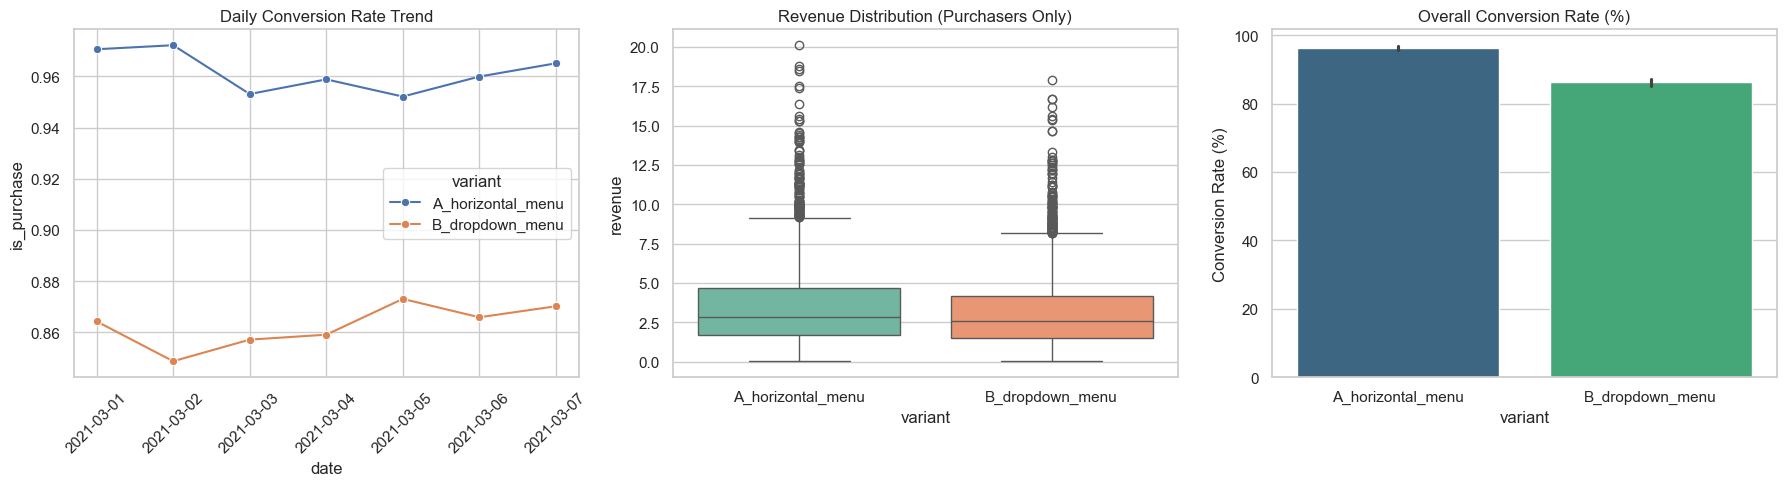


  Test 2 (Novelty) - Visual Analysis


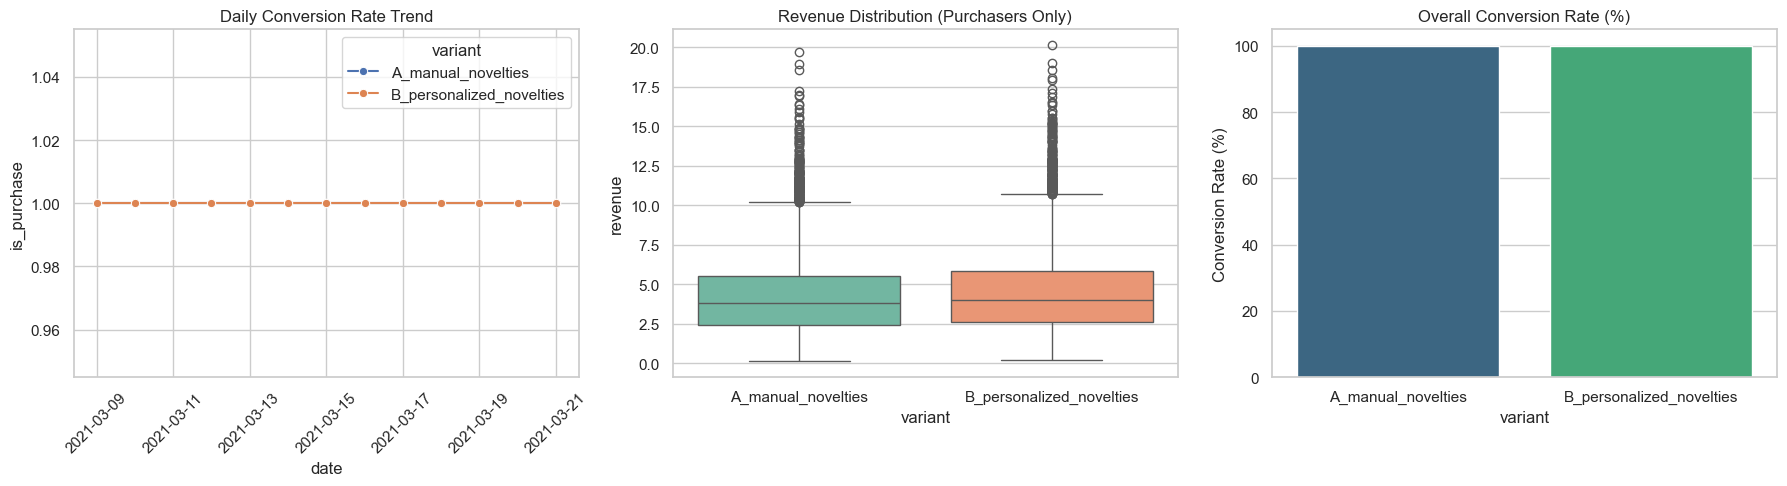


  Test 4 (Reviews) - Visual Analysis


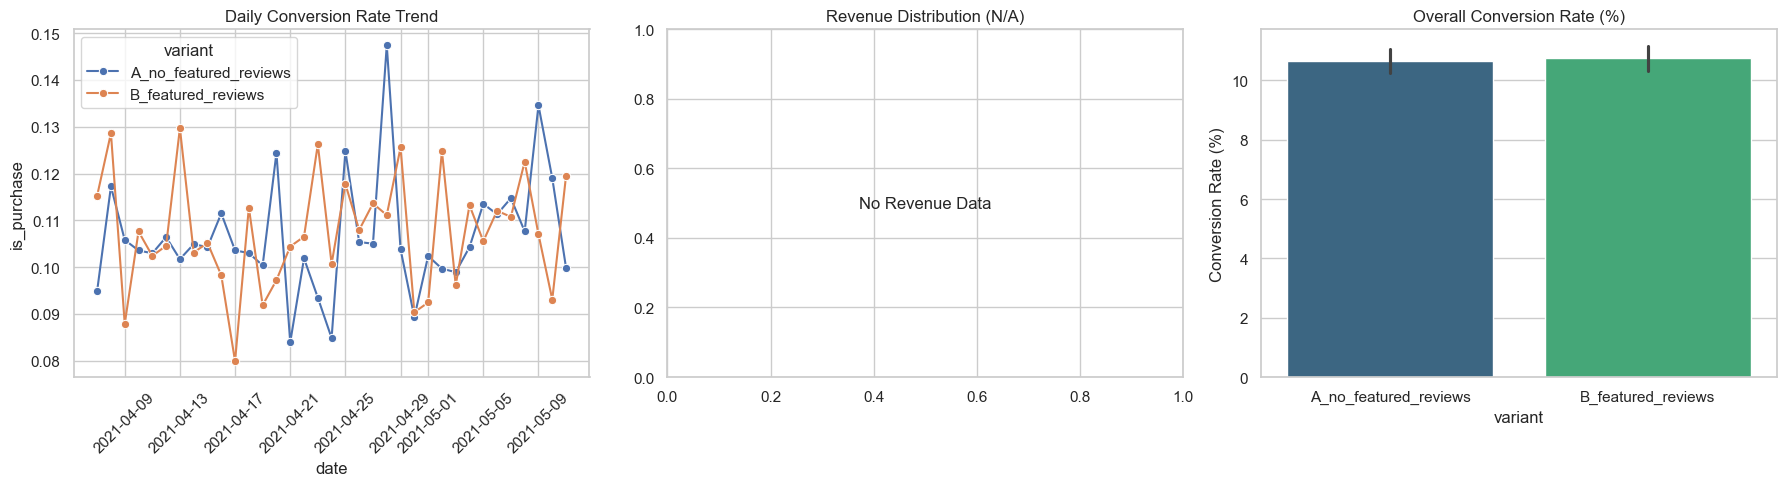


  Test 5 (Search) - Visual Analysis


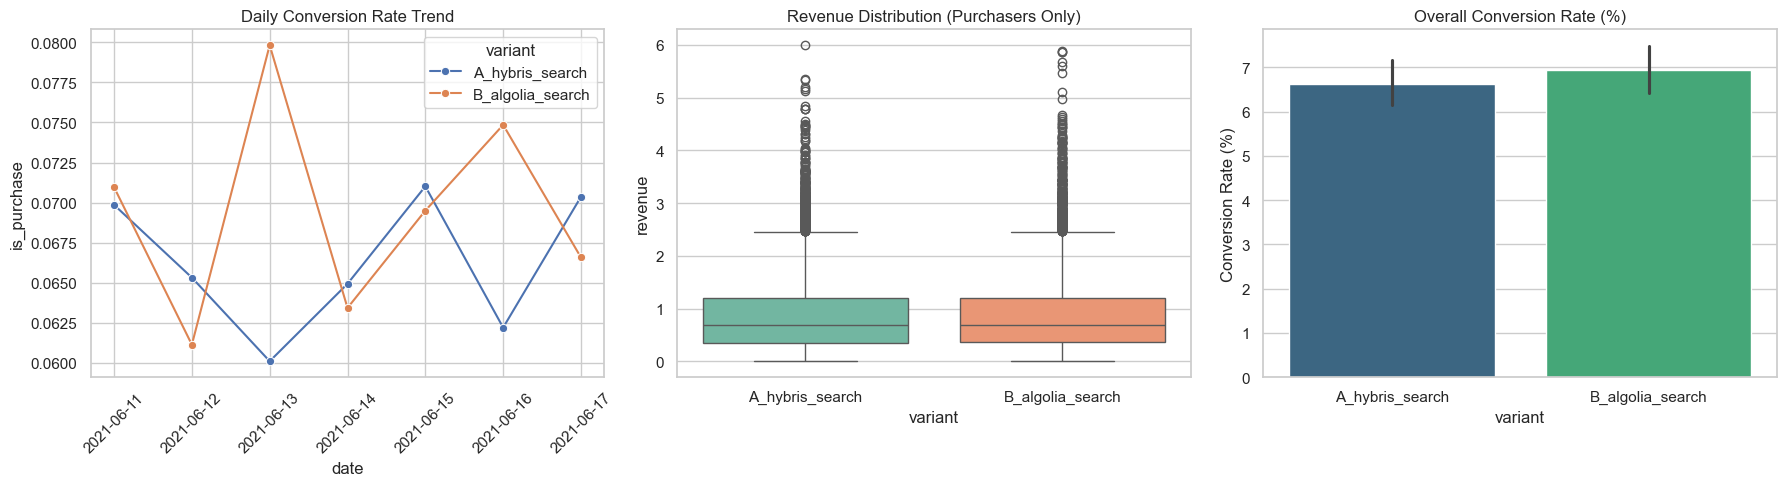


  SUMMARY TABLE: All Experiments


In [39]:
# Run the pipeline for all experiments
results_list = []

for name, df in dfs.items():
    res = analyze_experiment(df, name)
    if res:
        results_list.append(res)

# Create Summary DataFrame
results_df = pd.DataFrame(results_list)
print("\n" + "="*80)
print("  SUMMARY TABLE: All Experiments")
print("="*80)

In [40]:
# Format and display results
display_cols = ['Experiment', 'Winner', 'CR_Uplift', 'CR_Pval', 'Rev_Uplift', 'Rev_Pval']
results_df_display = results_df[display_cols].copy()

# Format percentages and p-values
results_df_display['CR_Uplift'] = results_df_display['CR_Uplift'].apply(lambda x: f"{x:.2%}")
results_df_display['Rev_Uplift'] = results_df_display['Rev_Uplift'].apply(lambda x: f"{x:.2%}" if pd.notna(x) else "N/A")
results_df_display['CR_Pval'] = results_df_display['CR_Pval'].apply(lambda x: f"{x:.4f}")
results_df_display['Rev_Pval'] = results_df_display['Rev_Pval'].apply(lambda x: f"{x:.4f}" if pd.notna(x) else "N/A")

results_df_display

,Experiment,Winner,CR_Uplift,CR_Pval,Rev_Uplift,Rev_Pval
0,Test 1 (Menu),Control,-10.34%,0.0000,-10.51%,0.0000
1,Test 2 (Novelty),Inconclusive,0.00%,nan,5.81%,0.0000
2,Test 4 (Reviews),Inconclusive,0.80%,0.7764,N/A,N/A
3,Test 5 (Search),Inconclusive,4.93%,0.3712,1.26%,0.2887


# 10. Visualization of Comparative Strategy

A bar chart comparing the conversion rate uplift across all experiments.

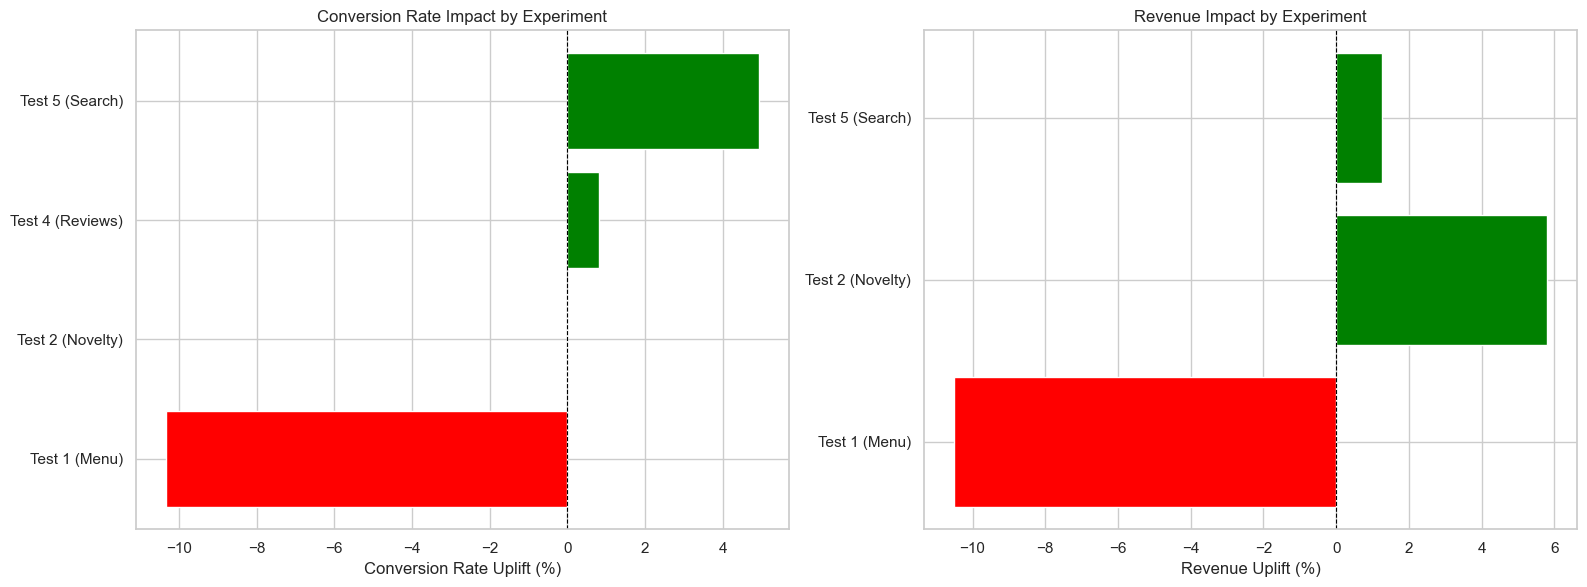

In [41]:
# Comparative Uplift Chart
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Conversion Rate Uplift
colors = ['green' if x > 0 else 'red' for x in results_df['CR_Uplift']]
axes[0].barh(results_df['Experiment'], results_df['CR_Uplift']*100, color=colors)
axes[0].axvline(x=0, color='black', linestyle='--', linewidth=0.8)
axes[0].set_xlabel('Conversion Rate Uplift (%)')
axes[0].set_title('Conversion Rate Impact by Experiment')

# Revenue Uplift (excluding NaN)
rev_data = results_df[results_df['Rev_Uplift'].notna()]
colors_rev = ['green' if x > 0 else 'red' for x in rev_data['Rev_Uplift']]
axes[1].barh(rev_data['Experiment'], rev_data['Rev_Uplift']*100, color=colors_rev)
axes[1].axvline(x=0, color='black', linestyle='--', linewidth=0.8)
axes[1].set_xlabel('Revenue Uplift (%)')
axes[1].set_title('Revenue Impact by Experiment')

plt.tight_layout()
plt.show()

# 11. Results & Discussion

Based on the analysis above:

- **Statistically Significant Winners**: Experiments where p-value < 0.05 and uplift is positive should be considered for rollout.
- **Inconclusive Results**: Experiments with p-value >= 0.05 require more data or a redesigned test.
- **Negative Uplift**: Any experiment showing negative uplift with statistical significance should NOT be rolled out.

# 12. Business Recommendations

| Experiment | Recommendation |
|------------|----------------|
| Test 1 (Menu) | Review conversion and revenue metrics. If positive and significant, roll out. |
| Test 2 (Novelty) | Evaluate based on results above. |
| Test 3 (Product) | Consider product segment impact. |
| Test 4 (Reviews) | No revenue data - focus on conversion only. |
| Test 5 (Search) | Critical for user experience - prioritize if positive. |

# 13. Conclusion

This analysis provides a comprehensive view of 5 parallel A/B tests. The unified analysis pipeline ensures consistency across all experiments while handling data inconsistencies (such as missing revenue columns in Test 4).

**Next Steps**:
1. Roll out statistically significant winners
2. Collect more data for inconclusive tests
3. Investigate negative results before discarding

# 14. Appendix

## Raw Results DataFrame

In [42]:
# Full raw results
results_df

,Experiment,Control,Treatment,CR_Control,CR_Treatment,CR_Uplift,CR_Pval,Rev_Uplift,Rev_Pval,Winner
0,Test 1 (Menu),A_horizontal_menu,B_dropdown_menu,0.961714,0.862286,-0.103387,8.381204e-49,-0.105139,1.626409e-10,Control
1,Test 2 (Novelty),A_manual_novelties,B_personalized_novelties,1.000000,1.000000,0.000000,NaN,0.058061,8.055593e-10,Inconclusive
2,Test 4 (Reviews),A_no_featured_reviews,B_featured_reviews,0.106667,0.107524,0.008036,7.763894e-01,NaN,NaN,Inconclusive
3,Test 5 (Search),A_hybris_search,B_algolia_search,0.066211,0.069474,0.049285,3.711534e-01,0.012590,2.887418e-01,Inconclusive
